In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
from scipy.interpolate import interp2d


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output, N):
    super().__init__()
    # optimisers    

    # constants and stuff
    self.r_rms, self.t_rms = self.sample(N)
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_rms.cpu().detach().numpy(), self.t_rms.cpu().detach().numpy())).to(device)
    self.N = N
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(N)
    self.j = -5.35e-5
    self.Rs = 2e-6
    self.c_max = 4.665e4
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16

    # storing D and loss values
    self.Ds = []
    self.loss_list = []

    # activation function
    activation = nn.Tanh

    # c network
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])
    self.fco = nn.Linear(depth, output)

    # D network
    self.fciD = nn.Sequential(*[nn.Linear(1, 32), activation()])
    self.fchD = nn.Sequential(*[nn.Sequential(*[nn.Linear(32, 32), activation()]) for i in range(2)])
    self.fcoD = nn.Linear(32, 1)

  # c forward propagation
  def forward_c(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    x = self.c0/self.c_max+t**0.5*x
    return x
  
  # D forward propagation
  def forward_D(self, x):
    x = self.fciD(x)
    x = self.fchD(x)
    x = self.fcoD(x)
    return x
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_rms, t_rms):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_rms)):
      r = np.round(10000 * r_rms[i]).astype(int)[0]
      t = np.round(400 * t_rms[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary

  def sample(self, N):
        
        # sample points for training
        r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
        t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
    
        return r, t
  
  def Diffusion_Coeff(self, c, D_ref):
    # constants
    #D_ref = 2e-16
    c_max = 4.665e4
    C_theory = 277.84
    C_practical = 160

    # equations
    SOC = (c_max - c*c_max)/c_max * C_theory/C_practical
    D = D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def deriv(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]

  def losses(self):
 
    r_phys, t_phys = self.sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0
  

    # loss for r = 0 boundary
    c = self.forward_c(self.r0_boundary, self.t_boundaries)
    c_r = self.deriv(c, self.r0_boundary)
    r0_loss = c_r**2
    
    # loss for x = rs boundary
    c = self.forward_c(self.rs_boundary, self.t_boundaries)
    c_r = self.deriv(c, self.rs_boundary)
    D = self.forward_D(c)
    rs_loss = (D*1e-13*c_r + j*Rs/c_max)**2
  
    # loss for t0 boundary
    c = self.forward_c(self.r_boundary, self.t0_boundary)
    t0_loss = (c_max*c - c0)**2

    # physics loss
    c = self.forward_c(r_phys, t_phys)
    c_r = self.deriv(c, r_phys)
    c_rr = self.deriv(c, r_phys)
    c_t = self.deriv(c, t_phys)

    D = self.forward_D(c)

    phys_loss = (r_phys**2*c_t - 2*r_phys*D*1e-13/Rs**2*c_r - r_phys**2*D*1e-13/Rs**2*c_rr)**2
    
    # comparative loss
    c = self.forward_c(self.r_rms, self.t_rms)
    comp_loss = torch.sub(c_max*c, self.c_numerical.unsqueeze(1))**2
    
    #print(torch.mean(r0_loss).item(), torch.mean(rs_loss).item(), torch.mean(t0_loss).item(), torch.mean(phys_loss).item(), torch.mean(rms_loss).item(), end='\r')
    loss = torch.mean(r0_loss) + torch.mean(rs_loss) + torch.mean(t0_loss) + torch.mean(phys_loss) + torch.mean(comp_loss)  
    #print(f'rms loss: {torch.mean(rms_loss).item()}  physics loss: {torch.mean(phys_loss).item()}  t0 loss: {torch.mean(t0_loss).item()}  rs loss: {torch.mean(rs_loss).item()}  r0 loss: {torch.mean(r0_loss).item()}')

    # store loss and D values
    self.loss_list.append(loss.item())

    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    # Adam
    optimizer_adam = torch.optim.Adam(self.parameters(), lr = lr_adam)
    for epoch in range(epochs_adam):
      
      optimizer_adam.zero_grad()
      loss = self.losses()
      loss.backward()
      optimizer_adam.step()
      print(f'Epoch: {epoch}  Loss: {loss.item()}', end='\r')

    # LBFGS
    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    for epoch in range(epochs_lbfgs):
      
      self.optimizer_lbfgs.step(self.closure)
      print(f'Epoch: {epochs_adam + epoch}  Loss: {self.loss_list[-1]}', end='\r')

    self.plot()
    self.plot_loss_Ds()
    self.plot_comparison()
    self.error()

    return self.losses
  


  def plot(self):

      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      X_grid, T_grid = torch.meshgrid(X, T)
      
      C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100)
      C = C.cpu().detach().numpy()
      print(C.shape)
      
      X, T = np.meshgrid(X.cpu().detach().numpy(), T.cpu().detach().numpy())
      fig = plt.figure()
      fig.clear()
      ax = fig.add_subplot(111, projection='3d')
      ax.plot_surface(X, T, C, cmap='viridis')
      
      plt.show()



  def plot_loss_Ds(self):

    c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    D = self.forward_D(c).cpu().detach().numpy()
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(c.cpu().detach().numpy()*self.c_max, np.log(D*10e-13))
    plt.xlabel('C')
    plt.ylabel('D')
    plt.title('Diffusion coefficient vs concentration')

    plt.subplot(1, 2, 2)
    plt.plot(self.loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')

    plt.tight_layout()
    plt.show()

  def plot_comparison(self):
    
    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device)
    T = torch.linspace(0, 1, 100).to(device)
    X_grid, T_grid = torch.meshgrid(X, T)
    
    C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = C.view(100, 100)
    C = C.cpu().detach().numpy()
    
    X = 10000*X.cpu().detach().numpy()
    T = 400*T.cpu().detach().numpy()
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    axs[0, 0].plot(numerical.iloc[:, 0])
    axs[0, 0].plot(X, C[..., 0])
    axs[0, 0].legend(['Numerical', 'NN'])
    axs[0, 0].set_title('Comparison at t=0')

    axs[0, 1].plot(numerical.iloc[:, -1])
    axs[0, 1].plot(X, C[:, -1])
    axs[0, 1].legend(['Numerical', 'NN'])
    axs[0, 1].set_title('Comparison at t=end')

    axs[1, 0].plot(numerical.iloc[0, :])
    axs[1, 0].plot(T, C[0, :])
    axs[1, 0].legend(['Numerical', 'NN'])
    axs[1, 0].set_title('Comparison at r=0')

    axs[1, 1].plot(numerical.iloc[-1, :]) 
    axs[1, 1].plot(T, C[-1, :])
    axs[1, 1].legend(['Numerical', 'NN'])
    axs[1, 1].set_title('Comparison at r=end')

    fig.tight_layout()
    fig.show()
    
    fig.legend(['Numerical', 'NN'])

  def error(self):
    
    
    X = torch.linspace(0, 0.99, 101).to(device)
    T = torch.linspace(0, 0.99, 101).to(device)
    X_grid, T_grid = torch.meshgrid(X, T)
    C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = C.view(101, 101)
    X, T = 10000*X.cpu().detach().numpy().astype(int), 400*T.cpu().detach().numpy().astype(int)

    numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
    numerical = numerical[np.ix_(X, T)]


    error = np.sqrt((numerical - C.cpu().detach().numpy())**2)
    X, T = np.meshgrid(X, T)
    
    fig = plt.figure()
    fig.clear()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, error, cmap='viridis')

    plt.show()

    


(100, 100) Loss: 728479.68755


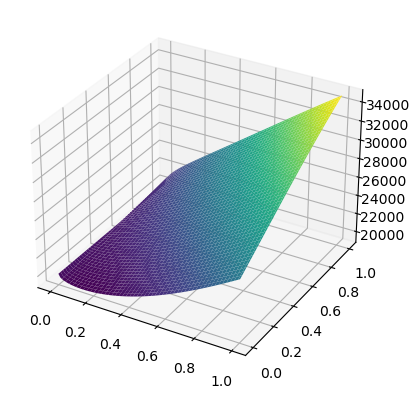

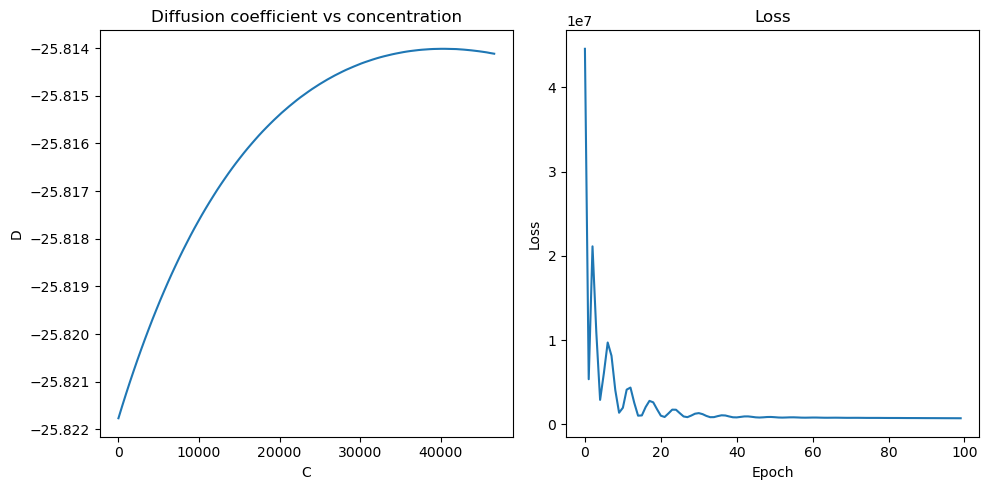

C:\Users\twcy2\AppData\Local\Temp\ipykernel_41280\773512059.py:263: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


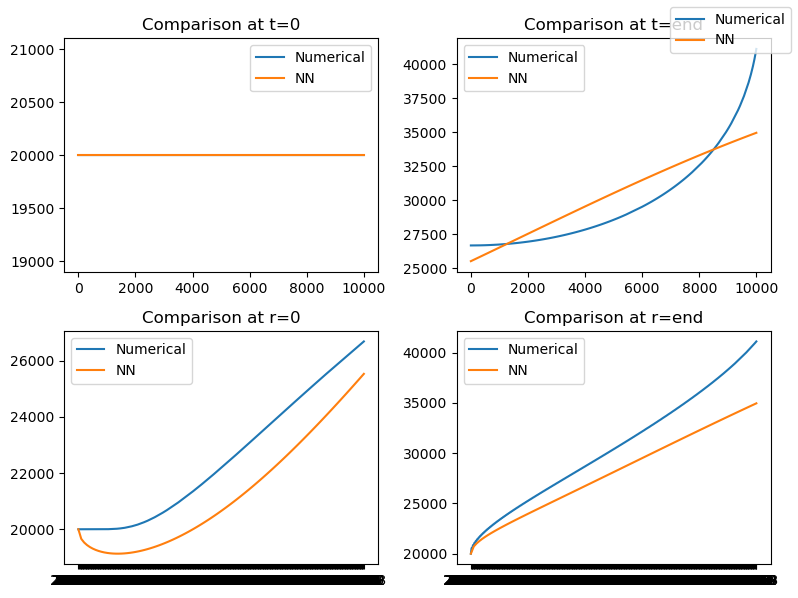

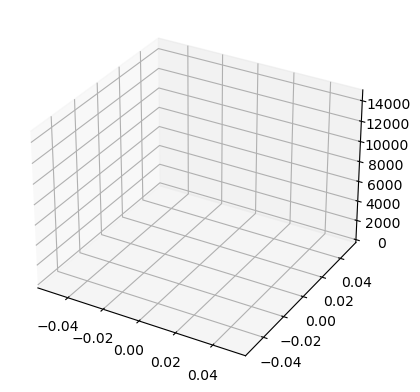

In [65]:
# nn seed
device = 'cuda'
N = 100
epochs_adam = 100
lr_adam = 1e-3
epochs_lbfgs = 0


# define nn to train, two inputs for x and t
pinn = Network(2, 5, 128, 1, N).to(device)


losses = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)

(100, 1) (100, 1)


ValueError: x and y must have same first dimension, but have shapes (100, 1) and (1,)

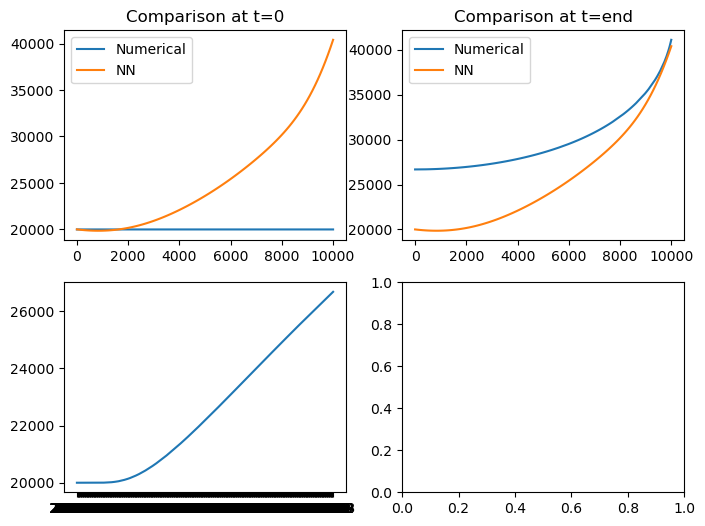

In [153]:
pinn.plot_comparison()

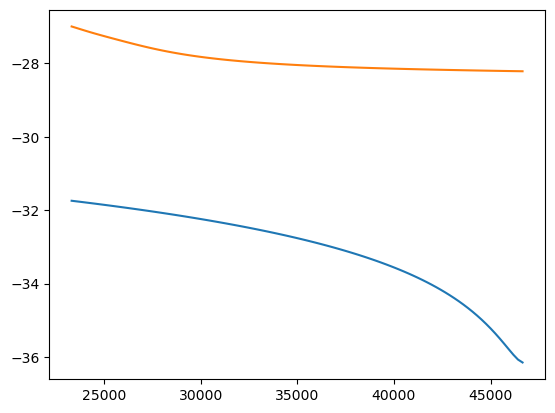

In [12]:
c = torch.linspace(0.5, 1, 100).view(-1, 1).to(device)
D = pinn.Diffusion_Coeff(c, 2e-16).cpu().detach().numpy()
Ds = pinn.forward_D(c).cpu().detach().numpy()
plt.plot(pinn.c_max*c.detach().cpu().numpy(), np.log(D))
plt.plot(pinn.c_max*c.detach().cpu().numpy(), np.log(Ds*1e-13))

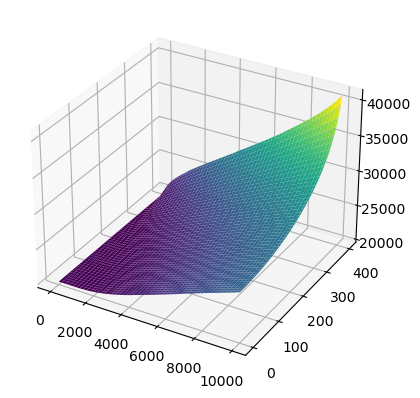

In [132]:
numerical = pd.read_csv("MATLAB Solver\data.csv")

X = np.round(10000 * np.linspace(0, 0.999, 100), 0)
T = np.round(400 * np.linspace(0, 0.999, 100), 0)


    
C = np.zeros((len(X), len(T)))
for i in range(len(X)):
    x = int(X[i])
    for j in range(len(T)):
        t = int(T[j]) 
        C[i, j] = numerical.iloc[x, t]
    
X, T = np.meshgrid(X, T)
fig = plt.figure()
fig.clear()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, C, cmap='viridis')
      
plt.show()




In [7]:
def train_and_time(network_size, epochs, lr, N, device):
    torch.manual_seed(938)

    # Define the NN
    pinn = Network(2, *network_size, 1).to(device)

    # Training
    start_time = time.time()
    Ds, losses = pinn.train(epochs, lr, N)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return elapsed_time

# Set up parameters
epochs = 3000
lr = 1e-3
N = 100

# Define network sizes to test
network_sizes = [
    (3, 32),
    (5, 32),
    (3, 128),
    (5, 128), 
    (5, 256), 
    (10, 256),
        
]

# Set random seed for reproducibility
torch.manual_seed(938)

elapsed_time_cpu = []
elapsed_time_gpu = []
# Train and time for each network size
for i in range(len(network_sizes)):
    size = network_sizes[i]
    elapsed_time_cpu.append = train_and_time(size, epochs, lr, N, 'cpu')
    elapsed_time_gpu.append = train_and_time(size, epochs, lr, N, 'cuda')

# Plot the results
plt.figure()
plt.plot(network_sizes, elapsed_time_cpu, label='CPU')
plt.plot(network_sizes, elapsed_time_gpu, label='GPU')
plt.xlabel('Network size')
plt.ylabel('Time (s)')
plt.legend()
plt.show()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)